Here we try and use VGG net since it has simpler architecture for small dataset which is perfect for our 50x50 pictures

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary

import sys
from pathlib import Path

#torch 
import torch
import torchvision as torchv
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import Tensor
from torch.utils import data
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

import pandas as pd
import seaborn as sn

In [2]:
#Metode for å hente data frå mappe
module_path = str(Path.cwd().parents[0].parents[0] / "methods")

if module_path not in sys.path:
    sys.path.append(module_path)

from dataloader import *
# from plotCreator import *

data_path0 = str(Path.cwd().parents[0].parents[0] / "data" / "BH_n4_M10_res50_15000_events.h5")
data_path1 = str(Path.cwd().parents[0].parents[0] / "data" / "PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_res50_15000_events.h5")

In [3]:
#Hente data og sette til array
bhArray = dataToArray(data_path0)
sphArray = dataToArray(data_path1)

In [4]:
#Kombinerer dataene for å kunne kjøre gjennom modellen på et samlet datasett
dataArray = np.concatenate((bhArray,sphArray),axis=0)

In [5]:
# Label array where BH is 0 and Sphalerons are 1
labelsArray = np.concatenate((np.zeros(np.shape(bhArray)[0]),np.ones(np.shape(sphArray)[0])),axis=0)

In [6]:
#Check if device is running on GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [7]:
#Split data 75% into train and 25% into test
trainData, testData, trainLabels, testLabels = train_test_split(dataArray, labelsArray, random_state=42)

Data augmentation process where we flip horizontally, vertically and rotate images by 180 degrees randomly thus increasing training set.

Commented out part where we crop images in width which can potentially increase models precision

In [8]:
def crop_image(img, crop_width_percent=0.8):
    width = img.shape[2]
    new_width = int(width * crop_width_percent)
    left_margin = (width - new_width) // 2
    return img[:, :, left_margin:left_margin + new_width]

def pad_image(img, original_width):
    width = img.shape[2]
    padding_width = (original_width - width) // 2
    return np.pad(img, ((0, 0), (0, 0), (padding_width, padding_width)), mode='constant')

def augment_images(images):
    images = np.moveaxis(images, -1, 1)
    augmented_images = []
    for img in images:
        original_width = img.shape[2]
        img_cropped = crop_image(img)
        img_padded = pad_image(img_cropped, original_width)
        img_flipped_horizontal = np.flip(img_padded, axis=2)
        img_flipped_vertical = np.flip(img_padded, axis=1)
        img_rotated_180 = np.rot90(img_padded, 2, axes=(1, 2))

        augmented_images.extend(
            [img_padded, img_flipped_horizontal, img_flipped_vertical, img_rotated_180]
        )
    return np.array(augmented_images)

# Apply data augmentation only on the training set
augmented_trainData = augment_images(trainData)

# Repeat the labels for the training set to match the augmented dataset
trainLabels_repeated = np.repeat(trainLabels, 4)

# Convert the augmented training data and repeated labels to PyTorch tensors
augmented_trainData = torch.from_numpy(augmented_trainData)
trainLabels_repeated = torch.from_numpy(trainLabels_repeated)

# Create a TensorDataset from the augmented training data and repeated labels
train_augmented = torch.utils.data.TensorDataset(augmented_trainData, trainLabels_repeated)

# Create a DataLoader for the augmented training dataset with shuffle enabled and batch size of 50
trainLoader_augmented = DataLoader(train_augmented, shuffle=True, batch_size=50)

# Apply the same preprocessing step to the test set as the training set
testData_processed = np.moveaxis(testData, -1, 1)

# Create a TensorDataset for the test data
test = torch.utils.data.TensorDataset(torch.from_numpy(testData_processed), torch.from_numpy(testLabels))

# Create a DataLoader for the test data with shuffle and batch size
testLoader = DataLoader(test, shuffle=True, batch_size=50)

This code allows us to look on orignial data image as well as its augmented forms

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


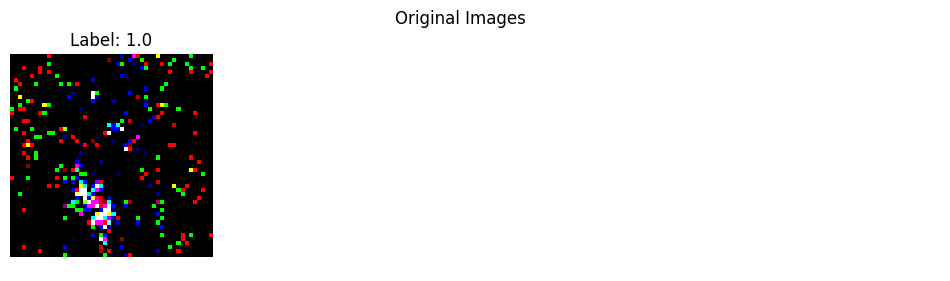

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


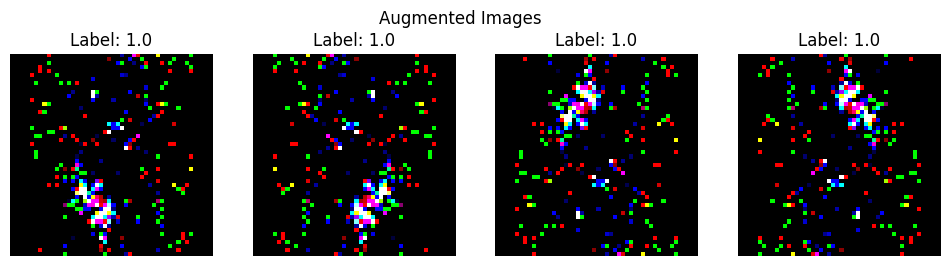

In [9]:
def visualize_single(images, labels, title="Images", augmentation_info=None):
    n_images = len(images)
    n_columns = 4
    n_rows = (n_images + n_columns - 1) // n_columns
    fig, axs = plt.subplots(n_rows, n_columns, figsize=(3 * n_columns, 3 * n_rows))
    fig.suptitle(title)

    for i in range(n_images):
        if isinstance(images[i], np.ndarray):
            img_rgb = np.moveaxis(images[i], 0, -1) if images[i].shape[0] == 3 else images[i]
        elif isinstance(images[i], torch.Tensor):
            img_rgb = np.moveaxis(images[i].numpy(), 0, -1)

        ax = axs[i // n_columns, i % n_columns] if n_rows > 1 else axs[i % n_columns]
        ax.imshow(img_rgb)
        ax.set_title(f"Label: {labels[i]}")
        if augmentation_info is not None:
            ax.set_xlabel(augmentation_info[i])
        ax.axis('off')

    for i in range(n_images, n_rows * n_columns):
        ax = axs[i // n_columns, i % n_columns] if n_rows > 1 else axs[i % n_columns]
        ax.axis('off')

    plt.show()


n_samples = 1
original_images = trainData[:n_samples]
original_labels = trainLabels[:n_samples]
augmented_images = augmented_trainData[:n_samples * 4]
augmented_labels = trainLabels_repeated[:n_samples * 4]

# Example augmentation info for each image
augmentation_info = ['Original'] + ['Flip' for _ in range(3)] + ['Rotate']

visualize_single(original_images, original_labels, title="Original Images", augmentation_info=augmentation_info[:n_samples])
visualize_single(augmented_images, augmented_labels, title="Augmented Images", augmentation_info=augmentation_info[n_samples:])

Here we make a call on nnmodel.py in methods fodler where all our models resign

In [10]:
import nnmodel

model = nnmodel.SymmetricNet(0.5).to(device)  # Move the model to the appropriate device

# Print the model summary, make sure to provide appropriate input size (3, 50, 50) for the 3-channel 50x50 images
summary(model, (3, 50, 50))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 48, 48]           3,584
       BatchNorm2d-2          [-1, 128, 48, 48]             256
            Conv2d-3          [-1, 128, 48, 48]           3,584
       BatchNorm2d-4          [-1, 128, 48, 48]             256
            Conv2d-5          [-1, 128, 48, 48]           3,584
       BatchNorm2d-6          [-1, 128, 48, 48]             256
            Conv2d-7          [-1, 128, 48, 48]           3,584
       BatchNorm2d-8          [-1, 128, 48, 48]             256
         AvgPool2d-9          [-1, 128, 24, 24]               0
        AvgPool2d-10          [-1, 128, 24, 24]               0
        AvgPool2d-11          [-1, 128, 24, 24]               0
        AvgPool2d-12          [-1, 128, 24, 24]               0
          Dropout-13          [-1, 128, 24, 24]               0
           Conv2d-14          [-1, 256,

Here we make a call on train method from methods folder file trainers.py where all training and testing happends as well as plotting of accuracy, loss, precision, recall etc.

Epoch: 1/4
Train Loss: 0.2623, Train Accuracy: 90.53%
Test Loss: 0.3027, Test Accuracy: 87.21%
Epoch: 2/4
Train Loss: 0.1924, Train Accuracy: 92.67%
Test Loss: 0.2226, Test Accuracy: 91.16%
Epoch: 3/4
Train Loss: 0.1763, Train Accuracy: 93.28%
Test Loss: 0.1918, Test Accuracy: 92.83%
Epoch: 4/4
Train Loss: 0.1615, Train Accuracy: 93.93%
Test Loss: 0.1635, Test Accuracy: 93.63%


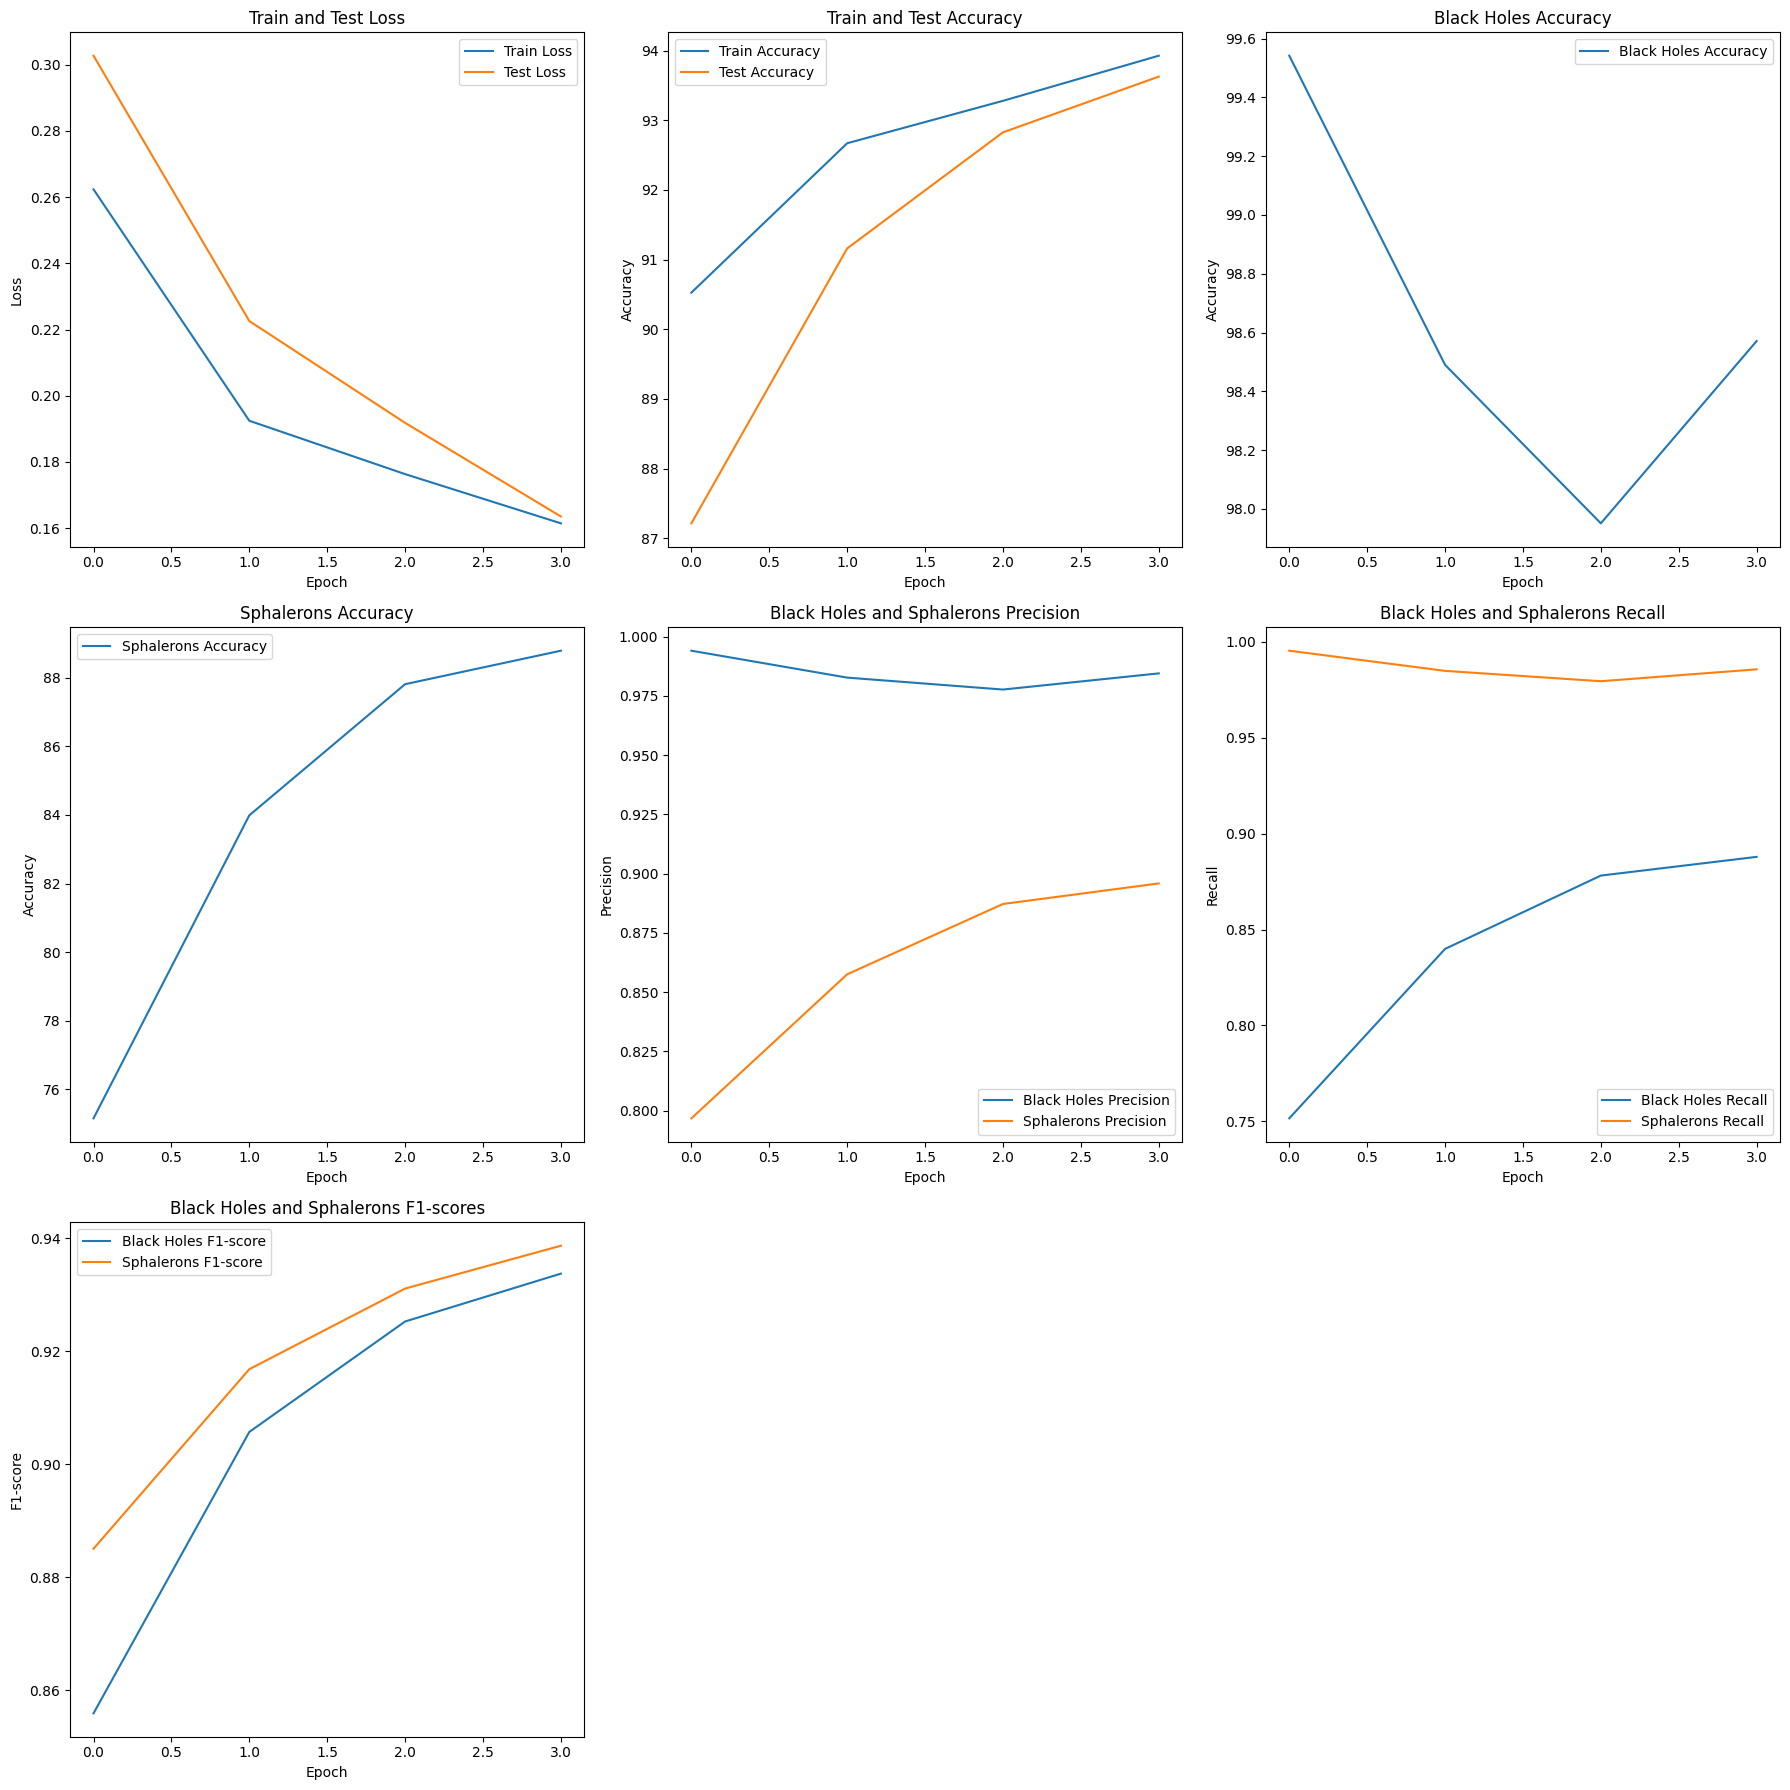

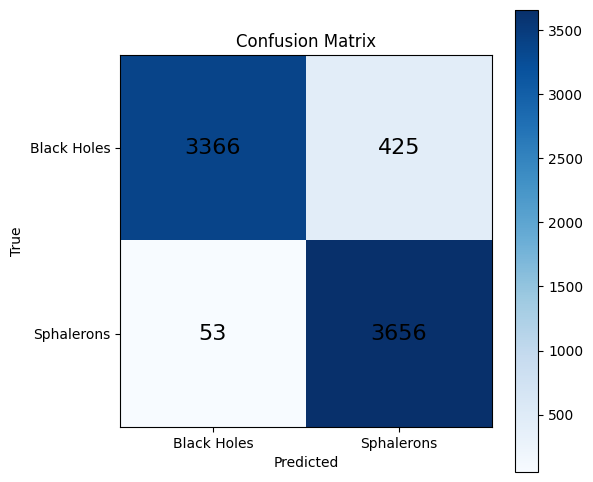

In [23]:
import trainer
#Set the learning rate and number of epochs
n_epochs = 4

model_save_path = "model_checkpoint_aug_VGGNet2.pth"

# Create the model
model = nnmodel.VGGNet(0.5).to(device)

# Set up the optimizer and criterion
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss().to(device)

# Train the model
trainer.train(model, trainLoader_augmented, testLoader, optimizer, criterion, n_epochs)

torch.save(model.state_dict(), model_save_path)

Code below makes it possible to save model

In [24]:
# Load the saved model
model.load_state_dict(torch.load(model_save_path))

# Set the model to evaluation mode
model.eval()

# Function to test the model
def test_model(model, test_loader, device):
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy of the model on test data: {accuracy}%")

# Test the model
test_model(model, testLoader, device)

Accuracy of the model on test data: 93.62666666666667%
